True
30394.936608996537  this is diff
(32, 3, 50, 50) (32,)
epoch: 0.05, loss_d: 1.5038, loss_g: 1.1436


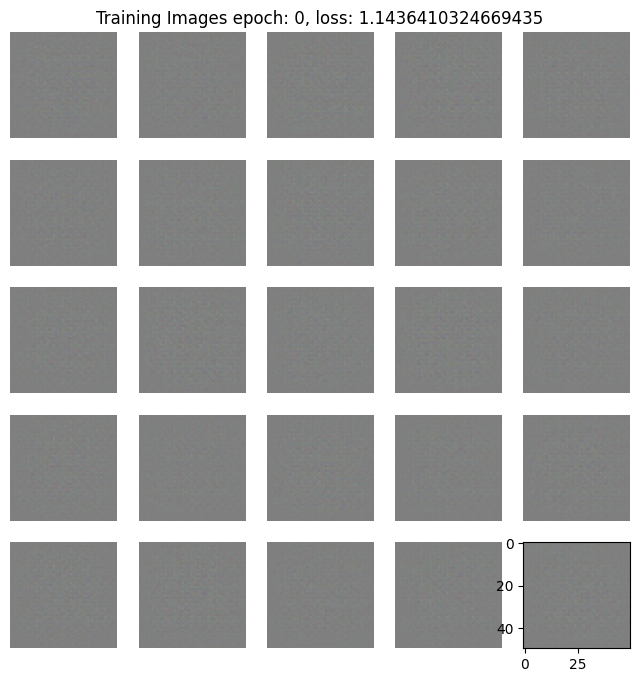

black diff between real sample:  174753.44419838526
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(29, 3, 50, 50) (29,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(32, 3, 50, 50) (32,)
(29, 3, 50, 50) (29,)
(3

KeyboardInterrupt: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from manual_diff_augment import DiffAugment, rand_brightness, rand_cutout, rand_contrast, rand_saturation, make_rgb_to_gray, make_rgb_to_black
import dezero
from dezero import cuda
import dezero.functions as F
import dezero.layers as L
from dezero import DataLoader
from dezero.models import Sequential
from dezero.optimizers import Adam
use_gpu = cuda.gpu_enable
print(use_gpu)

dict_data = np.load('8bit_characters_50x50.npz')
# extract the first array
data = dict_data['arr_0']
sample_data = data[0:32]
data_with_label = []
for i in range(len(data)):
    reshaped = np.transpose(data[i], (2, 0, 1))
    data_with_label.append((reshaped, i))
dataloader = DataLoader(data_with_label, batch_size=32, shuffle=True)


def init_weight(dis, gen,):
    # Input dummy data to initialize weights
    batch_size = 1
    z = np.random.rand(batch_size, 100, 1, 1)
    fake_images = gen(z)
    dis(fake_images)

    for l in dis.layers + gen.layers:
        classname = l.__class__.__name__
        if classname.lower() in ('conv2d', 'linear', 'deconv2d'):
            l.W.data = 0.02 * np.random.randn(*l.W.data.shape)


gen = Sequential(
    L.Deconv2d(in_channels=100, out_channels=512, kernel_size=5, stride=2, pad=0, nobias=True),
    L.BatchNorm(),
    F.relu,
    
    L.Deconv2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, pad=0, nobias=True),
    L.BatchNorm(),
    F.relu,

    L.Deconv2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.relu,

    L.Deconv2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, pad=1, nobias=True),
    F.tanh,
)

dis = Sequential(
    L.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, pad=1, nobias=True),
    F.leaky_relu,

    L.Conv2d(in_channels=32, out_channels=32*2, kernel_size=3, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=32*2, out_channels=32*4, kernel_size=5, stride=2, pad=1, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=32*4, out_channels=32*8, kernel_size=2, stride=2, pad=0, nobias=True),
    L.BatchNorm(),
    F.leaky_relu,

    L.Conv2d(in_channels=32*8, out_channels=1, kernel_size=3, stride=1, pad=0, nobias=True),
    F.sigmoid,
)

opt_g = Adam(alpha=0.0002, beta1=0.5).setup(gen)
opt_d = Adam(alpha=0.0002, beta1=0.5).setup(dis)

batch_size = 32

init_weight(dis, gen)

if use_gpu:
    gen.to_gpu()
    dis.to_gpu()
    dataloader.to_gpu()
    xp = cuda.cupy
else:
    xp = np

label_real = xp.ones(batch_size).astype(int)
label_fake = xp.zeros(batch_size).astype(int)
test_z = xp.random.randn(32,100, 1, 1)

def generate_image(epoch, loss):
    with dezero.test_mode():
        fake_images = gen(test_z)

    img = cuda.as_numpy(fake_images.data)
    img = (img + 1)/2
    img = np.transpose(img, (0, 2, 3, 1))
    fig = plt.figure(figsize = (8, 8))
    columns = rows = 5
    plt.title(f"Training Images epoch: {epoch}, loss: {loss}")
    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        if i >= len(img):
            break
        plt.imshow(img[i])
    plt.show()
    plt.close()
    return img



min_diff = 1 * 50 * 50 * batch_size

max_epoch = 1000

# policy = "color,cutout"

def grayscale_diff(x,y):
    gray_x = make_rgb_to_gray(x)
    gray_y = make_rgb_to_gray(y)
    squared = (gray_x - gray_y) ** 2
    diff = squared.sum()
    return diff

def black_diff(x,y):
    squared = (x - y) ** 2
    black_x = make_rgb_to_black(x)
    black_y = make_rgb_to_black(y)
    squared = (black_x - black_y) ** 2
    diff = squared.sum()
    return diff


print(black_diff(data[0:32], data[100:132]), ' this is diff')
 


for epoch in range(max_epoch):
    avg_loss_d = 0
    avg_loss_g = 0
    cnt = 0

    for x, t in dataloader:
        print(x.shape, t.shape)
        cnt += 1
        if len(t) != batch_size:
            continue

        # Update discriminator
        z = xp.random.randn(batch_size, 100, 1, 1).astype(np.float32)
        # x = DiffAugment(x, policy=policy,is_cuda=use_gpu)
        mod_x = rand_saturation(x, is_cuda=use_gpu)
        mod_x = rand_contrast(mod_x, is_cuda=use_gpu)
        mod_x = rand_cutout(mod_x, is_cuda=use_gpu)
        fake_images = gen(z)
        # fake_images = DiffAugment(fake_images, policy=policy, is_cuda=use_gpu)
        mod_fake_images = rand_saturation(fake_images, is_cuda=use_gpu)
        mod_fake_images = rand_contrast(mod_fake_images, is_cuda=use_gpu)
        mod_fake_images = rand_cutout(mod_fake_images, is_cuda=use_gpu)
        y_real = dis(mod_x)
        y_fake = dis(mod_fake_images)


        loss_d = F.binary_cross_entropy(y_real, label_real) +\
              F.binary_cross_entropy(y_fake, label_fake)
        gen.cleargrads()
        dis.cleargrads()
        loss_d.backward()
        opt_d.update()

        # Update generator
        y_fake = dis(mod_fake_images)
        loss_g = F.binary_cross_entropy(y_fake, label_real)
        gen.cleargrads()
        dis.cleargrads()
        loss_g.backward()
        opt_g.update()

        # Print loss & generate image
        avg_loss_d += loss_d.data
        avg_loss_g += loss_g.data
        if epoch % 100 == 0 and cnt == 1:
            epoch_dt = epoch + cnt / dataloader.max_iter
            print('epoch: {:.2f}, loss_d: {:.4f}, loss_g: {:.4f}'.format(
                epoch_dt, loss_d.data, loss_g.data))
            generate_image(epoch, loss_g.data)
            with dezero.test_mode():
                test_diff = gen(xp.random.randn(32,100, 1, 1))

            img_diff = cuda.as_numpy(test_diff.data)
            img_diff = (img_diff + 1)/2
            img_diff = np.transpose(img_diff, (0, 2, 3, 1))
            # diff = 0
            real_diff = cuda.as_numpy(x)
            real_diff = (real_diff + 1)/2
            real_diff = np.transpose(real_diff, (0, 2, 3, 1))
            diff = black_diff(img_diff, real_diff)

            print("black diff between real sample: ", diff)
            if diff < min_diff and epoch > 150:
                min_diff = diff
                print('saving weights')
                gen.save_weights(f'parameters_manual/gen_manual_epoch:{epoch}.npz')
                gen.to_gpu()
                # dis.save_weights(f'parameters_manual/dis_manual_epoch:{epoch}.npz')